In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import scanpy as sc
import seaborn as sns
import re
from copy import deepcopy
import matplotlib.image as mpimg
from dataset_handler import df_to_anndata, anndata_to_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
DIP_df = pd.read_csv('data_subsets/DIP_drp.csv', index_col=0)
DIP_df_bk = deepcopy(DIP_df)
DIP_ad = df_to_anndata(DIP_df)
DIP_ad_bk = deepcopy(DIP_ad)
print(DIP_ad)
DIP_df.head(10)

AnnData object with n_obs × n_vars = 2615 × 5
    obs: 'Idents', 'date', 'experiment', 'exp_time'
    var: 0


,DIP-gamma,DIP-beta,DIP-delta,DIP-theta,dpr8,Idents,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,0,1,2,0,27,6:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACTCGA,0,0,1,0,13,19:DN2,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_AGACCA,0,0,1,0,7,15:DN1p_CNMa,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_AGGAAG,0,3,1,0,7,19:DN2,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_CATGCA,1,13,0,1,7,3:DN1a,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_CTAGTG,0,0,3,1,2,2:s_LNv,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GAAGTG,1,0,2,3,19,7:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GACAAC,0,0,3,0,13,2:s_LNv,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GACAGA,0,1,2,2,3,18:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GAGTAC,0,0,0,0,15,9:LNd_NPF,2019-05-28,DD,CT02


In [9]:
idents = [ident for ident in DIP_ad.obs['Idents'].unique()]
idents.sort(key= lambda x : int(x.split(':')[0]))
for ident in idents:
    print(ident)

1:DN1p_CNMa
2:s_LNv
3:DN1a
4:DN1p
5:LNd_Trissin
6:DN1p
7:DN1p
8:LN_ITP
9:LNd_NPF
12:LNd
14:DN3
15:DN1p_CNMa
18:DN1p
19:DN2
20:DN3
25:l_LNv
29:LPN


### Part 1: Dot plots

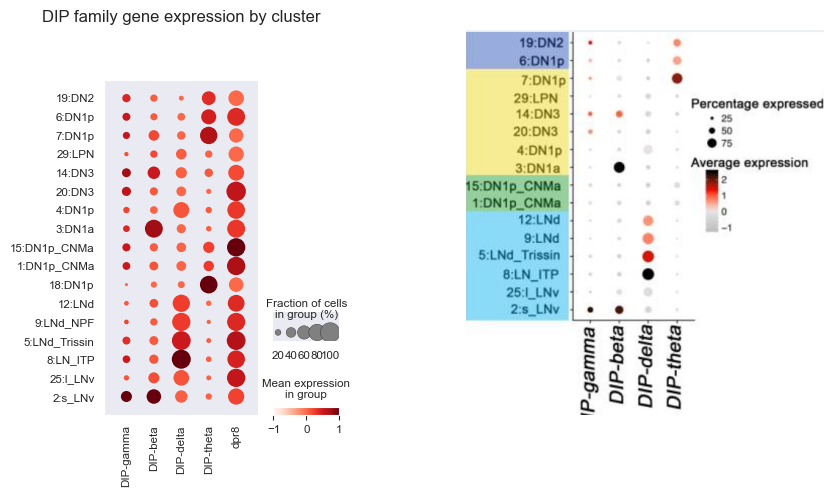

In [46]:
DIP_ad = deepcopy(DIP_ad_bk)
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})
fig6_B = mpimg.imread('fig6_B.png')
reorder = ["19:DN2", "6:DN1p", "7:DN1p", "29:LPN", "14:DN3", "20:DN3", "4:DN1p",
           "3:DN1a", "15:DN1p_CNMa", "1:DN1p_CNMa", "18:DN1p",
           "12:LNd", "9:LNd_NPF","5:LNd_Trissin", "8:LN_ITP", "25:l_LNv", "2:s_LNv"]
dotplot = sc.pl.DotPlot(DIP_ad,
                        var_names=DIP_ad.var_names,
                        groupby='Idents',
                        categories_order=reorder,
                        standard_scale='var',
                        vmin=-1,
                        vmax=1,
                        var_group_rotation=0.,
                        edgecolors=None,
                        mean_only_expressed=True,
                        title='DIP family gene expression by cluster',
                        cmap='Reds',
                        linewidth=0.,
                        ax=axs[0],)
dotplot.DEFAULT_CATEGORY_WIDTH = 0.7
dotplot.DEFAULT_CATEGORY_HEIGHT = 0.4
dotplot.DEFAULT_PLOT_Y_PADDING = 2
axs[1].imshow(fig6_B)
axs[1].axis('off')
dotplot.show()

### Part 2: Scatter plots for single gene

In [89]:
# retrieve original data and preprocess it
DIP_ad = deepcopy(DIP_ad_bk)
sc.pp.normalize_total(DIP_ad, target_sum=1e4, exclude_highly_expressed=True)
DIP_df = anndata_to_df(DIP_ad)

# remove CT/ZT and just keep the time
DIP_df['time'] = DIP_df['exp_time'].apply(lambda x : x[2:])

C:\Users\gonza\miniconda3\envs\psivenv\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


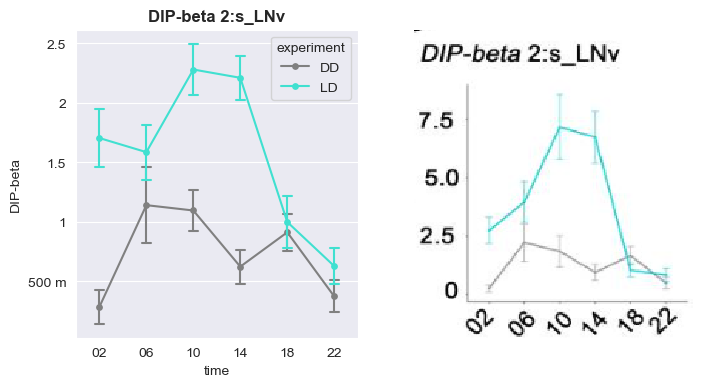

In [90]:
# plot with seaborn
gene = 'DIP-beta'
cluster = '2:s_LNv'
sns.set_palette('deep')
gene_palette = {"LD": 'turquoise', "DD": 'gray'}
fig6_D = mpimg.imread('fig6_D.png')


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].yaxis.set_major_formatter(ticker.EngFormatter())
axs[0].set_title(f"{gene} {cluster}", fontweight='semibold')
axs[1].imshow(fig6_D, interpolation='nearest', aspect='auto')
axs[1].axis('off')

sns.pointplot(DIP_df[DIP_df['Idents']==cluster],
              x='time',
              y=gene,
              hue='experiment', 
              estimator='mean',
              errorbar='se',
              palette=gene_palette,
              capsize=0.2,
              linewidth=1.5,
              ax=axs[0])
plt.show()